In [ ]:
%pip install owslib shapely matplotlib ipyleaflet rasterio

### Imports

In [1]:
from owslib.wps import WebProcessingService, ComplexDataInput, Authentication
import json
import pandas as pd
import logging
import sys
import io
import time
from ipyleaflet import Map, GeoJSON, basemaps

In [2]:
# Set up owslib logging, to set relevant output
logger = logging.getLogger("owslib")
logger.setLevel(logging.WARNING)

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.WARNING)
logger.addHandler(handler)

### Consts - Change these to affect the data retrieved

In [22]:
ENDPOINT="https://funcwps.ternlandscapes.org.au/wps/"
DATASET="aet"  # options are "smips" or "aet"
LAYER="ETa"  # options are "totalbucket" or "SMindex" for smips, or "ETa" for "aet".
BEGINDATE="2019-02-01"
ENDDATE="2019-06-30"
# Enter your POLYGON as GeoJSON format.
MY_POLYGON='{"type": "Polygon", "coordinates": [[[151.39067721041408, -25.817716701946395], [153.37920260103908, -25.401622912943335], [154.82466059609754, -27.879438356653793], [152.27583247109754, -28.392903179661957], [150.18843012734754, -27.539015050742954], [150.23237543984754, -26.599878666580576], [151.39067721041408, -25.817716701946395]]]}'

### Define a connection to the server

In [23]:
# Enter your TERN API key as password
TERN_APIKEY = "N045_example_U0RySC5DDEF_replace_me_JOVpQVkdXezZMeC5ZWwlaNHxwDDQtDHsu"
AUTH = Authentication("apikey", password=TERN_APIKEY, shared=True)
server = WebProcessingService(ENDPOINT, auth=AUTH)

In [24]:
print('WPS Identification type: %s' % server.identification.type)
print('WPS Identification title: %s' % server.identification.title)
print('WPS Identification abstract: %s' % server.identification.abstract)
for operation in server.operations:
    print('WPS Operation: %s' % operation.name)
for process in server.processes:
    print('WPS Process: identifier=%s title=%s' % (process.identifier, process.title))

WPS Identification type: WPS
WPS Identification title: TERN Landscapes Functional Data WPS Server
WPS Identification abstract: The Functional Data Processing Server from TERN Landscapes
WPS Operation: GetCapabilities
WPS Operation: DescribeProcess
WPS Operation: Execute
WPS Process: identifier=sleep title=Sleep Process
WPS Process: identifier=temporalDrill title=Temporal Drill
WPS Process: identifier=subset1d title=SubSet 1D
WPS Process: identifier=subset2d title=SubSet 2D
WPS Process: identifier=subset3d title=SubSet 3D
WPS Process: identifier=stats2d title=Stats 2D
WPS Process: identifier=stats3d title=Stats 3D


In [25]:
process = server.describeprocess("stats3d")
print('WPS Process: identifier=%s' % process.identifier)
print('WPS Process: title=%s' % process.title)
print('WPS Process: abstract=%s' % process.abstract)
for input in process.dataInputs:
    print('Process input: identifier=%s, data type=%s, minOccurs=%d, maxOccurs=%d' % (input.identifier, input.dataType, input.minOccurs, input.maxOccurs))
for output in process.processOutputs:
    print('Process output: identifier=%s, data type=%s' % (output.identifier, output.dataType))

WPS Process: identifier=stats3d
WPS Process: title=Stats 3D
WPS Process: abstract=Return CSV file containing timeseries stats within given 2D polygons.
Process input: identifier=datasetId, data type=string, minOccurs=1, maxOccurs=1
Process input: identifier=startDate, data type=date, minOccurs=1, maxOccurs=1
Process input: identifier=endDate, data type=date, minOccurs=1, maxOccurs=1
Process input: identifier=returnType, data type=string, minOccurs=0, maxOccurs=1
Process input: identifier=polygon, data type=ComplexData, minOccurs=1, maxOccurs=1
Process output: identifier=download_link, data type=string
Process output: identifier=csv, data type=ComplexData


### Optional - Visualize shape

In [26]:
m = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=[-25.128, 135.588], zoom=4)
m.add_layer(GeoJSON(data=json.loads(MY_POLYGON)))
m

Map(center=[-25.128, 135.588], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

### Set up to send request, first create inputs

In [27]:
poly_input = ComplexDataInput(MY_POLYGON, mimeType="application/vnd.geo+json", schema="http://geojson.org/geojson-spec.html#polygon")

### Trigger process to begin (process executes asynchronously)

In [35]:
resp3 = server.execute(
    "stats3d",
    mode="async",
    inputs=[("datasetId", f"{DATASET}:{LAYER}"), ("polygon", poly_input), ("startDate", BEGINDATE), ("endDate", ENDDATE)],
    output=[("csv", False, "text/csv")]  # Get stats as embedded file in result
)

### Wait for process to complete (polls every 4 seconds)

In [36]:
print("Waiting for process to complete...")
while True:
    resp3.checkStatus(sleepSecs=0)
    print(f"Progress: {resp3.percentCompleted}, {resp3.statusMessage}")
    if resp3.isComplete():
        break
    time.sleep(4)
print("Done")

Waiting for process to complete...
Progress: 0, Found 5 time slices to process,
Progress: 0, Found 5 time slices to process,
Progress: 0, Found 5 time slices to process,
Progress: 0, Found 5 time slices to process,
Progress: 0, Found 5 time slices to process,
Progress: 20, Completed 1 lookups
Progress: 20, Completed 1 lookups
Progress: 20, Completed 1 lookups
Progress: 20, Completed 1 lookups
Progress: 20, Completed 1 lookups
Progress: 40, Completed 2 lookups
Progress: 40, Completed 2 lookups
Progress: 40, Completed 2 lookups
Progress: 60, Completed 3 lookups
Progress: 60, Completed 3 lookups
Progress: 60, Completed 3 lookups
Progress: 80, Completed 4 lookups
Progress: 80, Completed 4 lookups
Progress: 80, Completed 4 lookups
Progress: 80, Completed 4 lookups
Progress: 100, Landscapes WPS Process succeeded
Done


### Extract CSV data and render it

In [37]:
first_output = next(iter(resp3.processOutputs))
data = "".join(d for d in first_output.data)
df = pd.read_csv(io.StringIO(data))
df

,date,feature,min,max,mean,valid,stddev
0,2019-02-01T00:00:00+00:00,0,0.0,10296.0,2399.079307,47.471226,1149.955540
1,2019-03-01T00:00:00+00:00,0,0.0,6745.0,2042.719289,47.471226,1022.736974
2,2019-04-01T00:00:00+00:00,0,0.0,5878.0,1919.889532,47.471226,737.076523
3,2019-05-01T00:00:00+00:00,0,0.0,5364.0,1394.686187,47.471226,605.392424
4,2019-06-01T00:00:00+00:00,0,0.0,4518.0,1108.305899,47.471226,561.789606


<Axes: xlabel='date'>

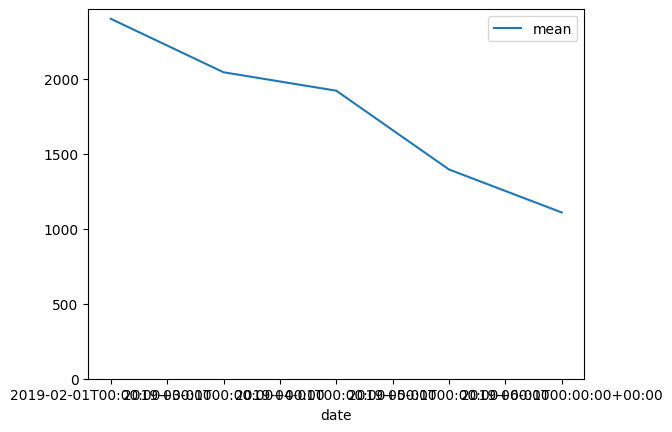

In [52]:
df.plot.line(x="date", y="mean", ylim=0)